In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score

# Load Data

In [3]:
baskets = pd.read_parquet("data/baskets.parquet")
baskets["week"] = baskets["week"].astype("uint8")
baskets["shopper"] = baskets["shopper"].astype("int32")
baskets["product"] = baskets["product"].astype("uint8")
baskets["price"] = baskets["price"].astype("uint16")
baskets["bought"] = 1
baskets["bought"] = baskets["bought"].astype("uint8")
baskets.head()

,week,shopper,product,price,bought
0,0,0,71,629,1
1,0,0,91,605,1
2,0,0,116,715,1
3,0,0,123,483,1
4,0,0,157,592,1


In [4]:
coupons = pd.read_parquet("data/coupons.parquet")
coupons["week"] = coupons["week"].astype("uint8")
coupons["shopper"] = coupons["shopper"].astype("int32")
coupons["product"] = coupons["product"].astype("uint8")
coupons["discount"] = coupons["discount"].astype("uint8")
coupons["coupon"] = 1
coupons["coupon"] = coupons["coupon"].astype("uint8")
coupons.head()

,week,shopper,product,discount,coupon
0,0,0,35,35,1
1,0,0,193,40,1
2,0,0,27,30,1
3,0,0,177,35,1
4,0,0,5,30,1


---
Multi-core summation that will calculate a crosstable of bought vs. not bought split by coupon sizes.
- First keyword is core count

Result will be a .csv in working directory

Running the script in command line will display a progress bar. It takes fairly long (3 minutes on 10 cores).

In [ ]:
# !crosstable_naive.py 10

In [5]:
crosstab = pd.read_csv("data/crosstable_by_discount.csv", names=["not bought", "bought"])
crosstab.index = [0, 10, 15, 20, 25, 30, 35, 40]
crosstab.index.rename("Discount", inplace=True)
crosstab["freq"] = crosstab["bought"] / (crosstab["bought"] + crosstab["not bought"])
crosstab["freq"] *= 100
crosstab

,not bought,bought,freq
Discount,,,
0,2.138866e+09,66133555.0,2.999254
10,6.169347e+06,260393.0,4.049822
15,6.126476e+06,298190.0,4.641331
20,6.087241e+06,338179.0,5.263142
25,6.048858e+06,382758.0,5.951195
30,5.999362e+06,428452.0,6.665594
35,5.954477e+06,474719.0,7.383800
40,5.906196e+06,525352.0,8.168360


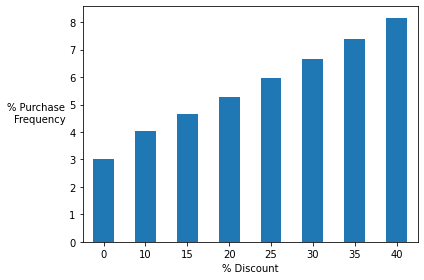

In [6]:
crosstab[["not bought", "bought"]] = crosstab[["not bought", "bought"]].astype("int")
crosstab.freq.plot.bar()
plt.ylabel("% Purchase\nFrequency", rotation=0, ha="right")
plt.xticks(rotation=0)
plt.xlabel("% Discount")
plt.tight_layout()
plt.savefig("freq_by_coupon.png");

# Construct Naive Benchmark

In [7]:
class Naive():
    def __init__(self):
        self.crosstab = pd.read_csv("data/crosstable_by_discount.csv", names=["not bought", "bought"])
        self.crosstab.index = [0, 10, 15, 20, 25, 30, 35, 40]
        self.crosstab.index.rename("Discount", inplace=True)
        self.crosstab["freq"] = self.crosstab["bought"] / (self.crosstab["bought"] + self.crosstab["not bought"])
        
    def predict(self, df):
        out = self.crosstab["freq"].loc[df.discount].reset_index().drop(columns="Discount").rename(columns={"freq": "pred"})
        return out
    


# Validate

In [8]:
# Only validate on 2000 random shoppers
shopper_ixs = np.random.choice(100000, size=2000, replace=False)

baskets_filter = baskets.shopper.isin(shopper_ixs) & (baskets.week >= 80)
coupons_filter = coupons.shopper.isin(shopper_ixs) & (coupons.week >= 80)

# Merge these first to get smaller joins
basket_coupon = baskets[baskets_filter].merge(coupons[coupons_filter], how="outer")

# Densify coupon and basket data
densified_df = pd.DataFrame({"week": sorted(list(range(80, 90)) * 250 * 2000),
                       "shopper": sorted(shopper_ixs.tolist() * 250) * 10,
                       "product": list(range(250)) * 10 * 2000})

densified_df["week"] = densified_df["week"].astype("uint8")
densified_df["shopper"] = densified_df["shopper"].astype("int32")
densified_df["product"] = densified_df["product"].astype("uint8")

densified_df = densified_df.merge(basket_coupon, on=["week", "shopper", "product"], how="left").fillna(0)

densified_df["pred"] = Naive().predict(densified_df)

In [9]:
densified_df

,week,shopper,product,price,bought,discount,coupon,pred
0,80,32,0,0.0,0.0,0.0,0.0,0.029993
1,80,32,1,0.0,0.0,0.0,0.0,0.029993
2,80,32,2,0.0,0.0,0.0,0.0,0.029993
3,80,32,3,0.0,0.0,0.0,0.0,0.029993
4,80,32,4,0.0,0.0,0.0,0.0,0.029993
...,...,...,...,...,...,...,...,...
4999995,89,99850,245,0.0,0.0,0.0,0.0,0.029993
4999996,89,99850,246,0.0,0.0,0.0,0.0,0.029993
4999997,89,99850,247,0.0,0.0,0.0,0.0,0.029993
4999998,89,99850,248,0.0,0.0,0.0,0.0,0.029993


In [10]:
log_loss(densified_df.bought, densified_df.pred)

0.13648436786568088

In [11]:
roc_auc_score(densified_df.bought, densified_df.pred)

0.510146685022713

In [12]:
average_precision_score(densified_df.bought, densified_df.pred)

0.032278145224672296

# Get Elasticity

Since predictions are the same everywhere and only depend on discount, we can simply calculate own-product elasticity directly using the frequencies from the crosstable:

In [13]:
(crosstab.loc[30, "freq"] - crosstab.loc[0, "freq"]) / (0.3 * crosstab.loc[0, "freq"])

4.074724148758981